# Sentiment Analysis
*Jannik Labs, 2023*
*Master "Applied Data Science" @ Nordakademie*
*Modul: Text Analytics*

## Intro

Different approaches/methods or respective libraries possible for mapping sentiment values to the "cleaned_articles_v1.csv". Each coming in with its own characteristics, weaknesses and strengths:

1. **TextBlob**
- beginner-friendly and relatively easy to set up
- pre-trained models for sentiment analysis
- suitable for basic sentiment analysis tasks
- limited customization options

2. **NLTK Toolkit** - in general
- wide range of tools for text processing, including sentiment analysis
- more flexibility for creating custom sentiment analysis models

    - **VADER**-- (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner) (PART OF NLTK)
    - specific for Social Media, especially for informal texts like tweets and social media posts
    - lexicon-based and comes with a pre-trained sentiment lexicon
    - good for real-time sentiment analysis

3. **Scikit-learn**
- can be used to build a custom sentiment analysis model using machine learning
- allows engineering of custom features for sentiment analysis

4. **Transformer Models like BERT or GPT**
- State-of-the-Art Models: Utilizes pre-trained transformer-based models (e.g., BERT, GPT) for sentiment analysis
- High Performance: Provides state-of-the-art performance in NLP tasks
- requires significant computational resources and large amounts of data

### Decision
For our use case custom sentiment models with special features are rather out of scope. Neither do we mainly analyse really short texts as found on Social Media (tweets on X etc.). Therefore, in order to ensure comparisons of different tools/libraries, here we will use:

- TextBlob
- NLTK Toolkit (using VADER) (still used for a comparison)
- BERT (later specified)

As ressource heaviness increases these tools will be used in this exact order.

## Sentiment Analyses

### General pre-work

In [1]:
# Import necessary libraries

# Overall needed
import pandas as pd # to work with data frames
import numpy as np

# Needed for sentiment analyses and different approaches
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import torch
import torch.nn.functional as F # Import softmax function from torch.nn.functional
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from scipy.special import softmax
from transformers import LongformerTokenizer, LongformerForSequenceClassification

# Needed for visualisations and smaller functions such as time tracking or saving files
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import os # to define a dedicated output folder
import time # to track the run time for different approaches
import random

output_folder = 'data/sentiment_results' # refer to a new folder to store only sentiment result files

# check if folder can be found, else create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jannik.labs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Load the CSV file from the data cleaning part

csv_file_path = 'data/transfer/cleaned_articles_v1.csv' # define the path of the input csv file

# Load the data set, with the option of defining only a subset of the data (first x rows as an example). This way we can test ALL our approaches first and see some first results. Just use parameter "nrows=x". Total row number of the input is around 23.500.
df = pd.read_csv(csv_file_path, encoding='utf-8', quoting=csv.QUOTE_ALL, nrows=150) # ensuring the right encoding as in the csv file we still encounter incorrectly encoded special characters
total_rows = len(df) #define total rows

# Add a new column 'Row_Number' with the row number as the merge key for later
#df['Row_Number'] = range(1, len(df) + 1)

# Add a new column 'Row_Number' with the row number as the merge key for later
df.insert(0, 'Row_Number', range(1, len(df) + 1))

# Print the DataFrame with the row number as the first column
print(df)

# Create separate data frame copies for the sentiment analysis approaches
df_textblob = df.copy()       # For TextBlob approach
df_nltk = df.copy()           # For NLTK approach
df_bert_large = df.copy()     # for BERT approach with BERT-large
df_bert_roberta = df.copy()   # for BERT approach with RoBERTa
df_longformer = df.copy()  # for BERT approach with Longform

     Row_Number           Unternehmen       Newstyp   Quelle Nearest_Date  \
0             1  Heidelberg Materials          News  onvista   2021-06-02   
1             2       Sartorius (Vz.)          News  onvista   2021-06-04   
2             3       Sartorius (Vz.)          News  onvista   2021-06-08   
3             4              Covestro          News  onvista   2021-06-09   
4             5              Covestro          News  onvista   2021-06-09   
..          ...                   ...           ...      ...          ...   
145         146              Covestro          News  onvista   2021-10-19   
146         147         Hannover Rück          News  dpa-AFX   2021-10-18   
147         148         Hannover Rück          News  dpa-AFX   2021-10-18   
148         149         Deutsche Bank  Marktbericht  dpa-AFX   2021-10-18   
149         150         Hannover Rück          News  dpa-AFX   2021-10-18   

                                          Cleaned_Text    Stock_Value  
0  

### 1st Approach with TextBlob

In [3]:
used_approach = "TextBlob"  # Setting it for later reference

# Initialize a counter for tracking progress
current_row = 0

# Record the start time
start_time = time.time()

# Defining function for sentiment analysis
def analyze_sentiment(text):
    global current_row
    current_row += 1
    print(f"Analyzing text number {current_row} out of {total_rows} rows in the input file.")

    analysis = TextBlob(text)
    sentiment_score = analysis.sentiment.polarity
    if sentiment_score > 0:
        sentiment_label = 'Positive'
    elif sentiment_score == 0:
        sentiment_label = 'Neutral'
    else:
        sentiment_label = 'Negative'

    return sentiment_label, sentiment_score  # Return both label and score

# Applying the defined sentiment analysis function
df_textblob[['TextBlob_Sentiment_Label', 'TextBlob_Sentiment_Score']] = df_textblob['Cleaned_Text'].apply(analyze_sentiment).apply(pd.Series)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print("-"*100)

Analyzing text number 1 out of 150 rows in the input file.
Analyzing text number 2 out of 150 rows in the input file.
Analyzing text number 3 out of 150 rows in the input file.
Analyzing text number 4 out of 150 rows in the input file.
Analyzing text number 5 out of 150 rows in the input file.
Analyzing text number 6 out of 150 rows in the input file.
Analyzing text number 7 out of 150 rows in the input file.
Analyzing text number 8 out of 150 rows in the input file.
Analyzing text number 9 out of 150 rows in the input file.
Analyzing text number 10 out of 150 rows in the input file.
Analyzing text number 11 out of 150 rows in the input file.
Analyzing text number 12 out of 150 rows in the input file.
Analyzing text number 13 out of 150 rows in the input file.
Analyzing text number 14 out of 150 rows in the input file.
Analyzing text number 15 out of 150 rows in the input file.
Analyzing text number 16 out of 150 rows in the input file.
Analyzing text number 17 out of 150 rows in the i

In [4]:
# Calculate hours, minutes, and seconds from the elapsed time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

# Format the elapsed time string
elapsed_time_str = f"{hours} hours, {minutes} mins, and {seconds} secs"

# End information about the run
print(f"The used approach was {used_approach}.")
print(f"Elapsed time: {elapsed_time_str}.")

The used approach was TextBlob.
Elapsed time: 0 hours, 0 mins, and 0 secs.


In [5]:
# Saving the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to an Excel file
excel_output_file_textblob = os.path.join(output_folder, 'sentiment_results_textblob.xlsx')
df_textblob.to_excel(excel_output_file_textblob, index=False)

# Save the results to a csv file with the same name
csv_output_file_textblob = os.path.join(output_folder, 'sentiment_results_textblob.csv')
df_textblob.to_csv(csv_output_file_textblob, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_textblob} and {excel_output_file_textblob}.")

Results saved as data/sentiment_results\sentiment_results_textblob.csv and data/sentiment_results\sentiment_results_textblob.xlsx.


### Explorative Analysis of TextBlob

In [6]:
# Calculate and print statistics

print("Statistics for TextBlob_Sentiment_Score:")

print("\nAverage Score:")
print(df_textblob['TextBlob_Sentiment_Score'].mean())
print("\nMinimum Score:")
print(df_textblob['TextBlob_Sentiment_Score'].min())
print("\nMaximum Score:")
print(df_textblob['TextBlob_Sentiment_Score'].max())
print("\nStandard Deviation:")
print(df_textblob['TextBlob_Sentiment_Score'].std())

# statistics for 'TextBlob_Sentiment_Label'
print("\nStatistics for TextBlob_Sentiment_Label:")
print("Count of values:")
print(df_textblob['TextBlob_Sentiment_Label'].value_counts())

Statistics for TextBlob_Sentiment_Score:

Average Score:
-0.013295154791745709

Minimum Score:
-0.2

Maximum Score:
0.7

Standard Deviation:
0.12473367997127782

Statistics for TextBlob_Sentiment_Label:
Count of values:
Negative    77
Neutral     38
Positive    35
Name: TextBlob_Sentiment_Label, dtype: int64


In [7]:
# Check some results of TextBlob including all columns

# Randomly sample 5 positive entries
positive_entries = df_textblob[df_textblob['TextBlob_Sentiment_Score'] > 0].sample(5, random_state=42)

# Randomly sample 5 negative entries
negative_entries = df_textblob[df_textblob['TextBlob_Sentiment_Score'] < 0].sample(5, random_state=42)

# Concatenate the positive and negative entries along with all columns
sampled_entries = pd.concat([positive_entries, negative_entries])

# Display all columns for the sampled entries
print(sampled_entries)

     Row_Number           Unternehmen Newstyp   Quelle Nearest_Date  \
124         125                   SAP    News  onvista   2021-10-13   
45           46                   SAP    News  onvista   2021-07-20   
116         117               Zalando    News  onvista   2021-10-07   
112         113                Adidas    News  onvista   2021-10-04   
71           72                Adidas    News  onvista   2021-08-13   
9            10                   SAP    News  onvista   2021-06-16   
67           68  Heidelberg Materials    News  onvista   2021-08-09   
16           17              Covestro    News  onvista   2021-06-23   
0             1  Heidelberg Materials    News  onvista   2021-06-02   
81           82                Adidas    News  onvista   2021-08-25   

                                          Cleaned_Text    Stock_Value  \
124  Onvista Mahlzeit Dax mutig Curevac sap Solarwe...  very_positive   
45   sap Führungswechsel Coronakrise strategisch um...       negative   

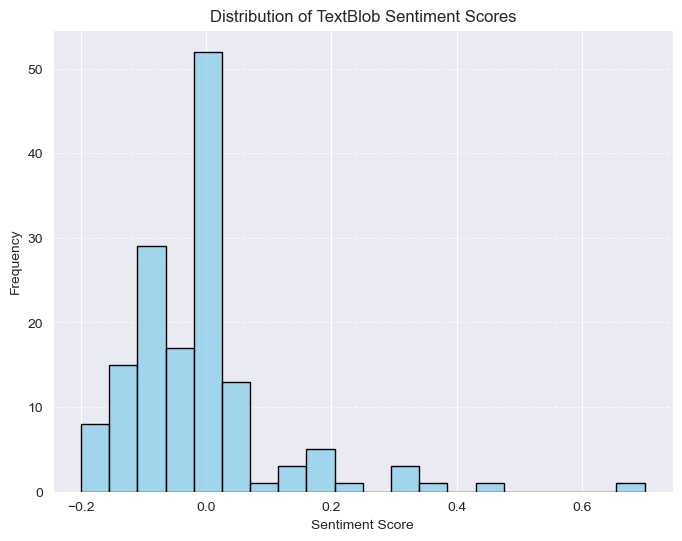

In [8]:
# Create a histogram for sentiment scores in df_textblob
plt.figure(figsize=(8, 6))
sns.histplot(df_textblob['TextBlob_Sentiment_Score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of TextBlob Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

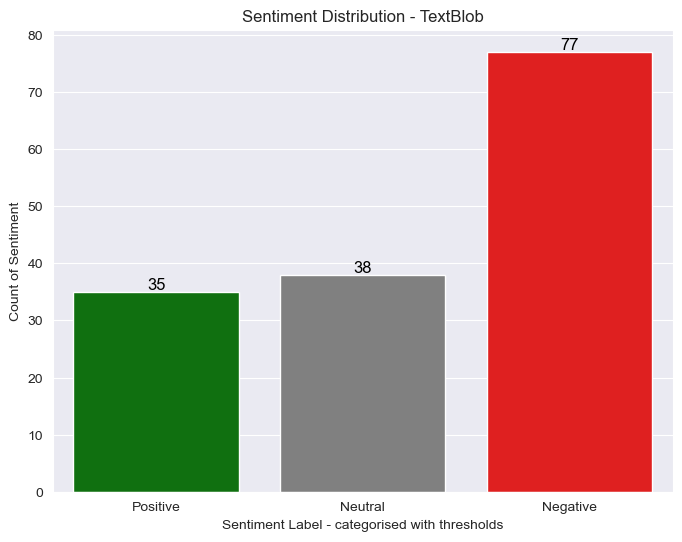

In [9]:
# Plot regarding the labels

# Count the occurrences of each sentiment label
sentiment_counts = df_textblob['TextBlob_Sentiment_Label'].value_counts()

# Define the order of sentiment categories
sentiment_order = ['Positive', 'Neutral', 'Negative']

# Define colors for the sentiment categories
colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}

# Create a bar plot (histogram) for sentiment distribution with correct colors and order
plt.figure(figsize=(8, 6))
sns.set_palette([colors[s] for s in sentiment_order])
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, order=sentiment_order)
plt.title('Sentiment Distribution - TextBlob')
plt.xlabel('Sentiment Label - categorised with thresholds')
plt.ylabel('Count of Sentiment')

# Add labels with integer values of counts to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

### 2nd Approach with NLTK (VADER)

In [10]:
used_approach = "NLTK_VADER" #setting it for later reference

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis and store the compound score in a new column
df_nltk['NLTK_Sentiment'] = df_nltk['Cleaned_Text'].apply(lambda text: sia.polarity_scores(text)['compound'])

In [11]:
# Apply sentiment analysis and store the compound score in a new column

# Record the start time
start_time = time.time()

for i, row in enumerate(df_nltk.index):
    text = df_nltk.at[row, 'Cleaned_Text']
    sentiment_score = sia.polarity_scores(text)['compound']
    df_nltk.at[row, 'NLTK_Sentiment'] = sentiment_score

    # Print progress message
    print(f"Text number {i + 1} out of all {total_rows} rows in the input file: Sentiment score = {sentiment_score}.")

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print("-"*100)

Text number 1 out of all 150 rows in the input file: Sentiment score = -0.4588.
Text number 2 out of all 150 rows in the input file: Sentiment score = 0.2023.
Text number 3 out of all 150 rows in the input file: Sentiment score = 0.0.
Text number 4 out of all 150 rows in the input file: Sentiment score = 0.4019.
Text number 5 out of all 150 rows in the input file: Sentiment score = -0.0516.
Text number 6 out of all 150 rows in the input file: Sentiment score = 0.6249.
Text number 7 out of all 150 rows in the input file: Sentiment score = 0.872.
Text number 8 out of all 150 rows in the input file: Sentiment score = 0.4588.
Text number 9 out of all 150 rows in the input file: Sentiment score = 0.4215.
Text number 10 out of all 150 rows in the input file: Sentiment score = 0.0.
Text number 11 out of all 150 rows in the input file: Sentiment score = 0.0.
Text number 12 out of all 150 rows in the input file: Sentiment score = -0.4019.
Text number 13 out of all 150 rows in the input file: Se

In [12]:
# Calculate hours, minutes, and seconds from the elapsed time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

# Format the elapsed time string
elapsed_time_str = f"{hours} hours, {minutes} mins, and {seconds} secs"

# End information about the run
print(f"The used approach was {used_approach}.")
print(f"Elapsed time: {elapsed_time_str}.")

The used approach was NLTK_VADER.
Elapsed time: 0 hours, 0 mins, and 0 secs.


In [13]:
# Saving the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to an Excel file
excel_output_file_nltk = os.path.join(output_folder, 'sentiment_results_nltk.xlsx')
df_nltk.to_excel(excel_output_file_nltk, index=False)

# Save the results to a csv file with the same name
csv_output_file_nltk = os.path.join(output_folder, 'sentiment_results_nltk.csv')
df_nltk.to_csv(csv_output_file_nltk, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_nltk} and {excel_output_file_nltk}.")

Results saved as data/sentiment_results\sentiment_results_nltk.csv and data/sentiment_results\sentiment_results_nltk.xlsx.


### Explorative Analysis of NLTK (VADER)

In [14]:
# Calculate and print statistics for 'NLTK_Sentiment_Score' in df_nltk
print("Statistics for NLTK Sentiment Score:")

# Average Score
print("\nAverage Score:")
print(df_nltk['NLTK_Sentiment'].mean())

# Minimum Score
print("\nMinimum Score:")
print(df_nltk['NLTK_Sentiment'].min())

# Maximum Score
print("\nMaximum Score:")
print(df_nltk['NLTK_Sentiment'].max())

# Standard Deviation
print("\nStandard Deviation:")
print(df_nltk['NLTK_Sentiment'].std())

Statistics for NLTK Sentiment Score:

Average Score:
-0.04157

Minimum Score:
-0.9062

Maximum Score:
0.9485

Standard Deviation:
0.4544470654195671


In [15]:
# Check some results of NLTK (VADER)

# Sort the DataFrame by sentiment scores (positive to negative)
df_nltk_sorted = df_nltk.sort_values(by='NLTK_Sentiment', ascending=False)

# Select the 5 most positive entries
most_positive_entries = df_nltk_sorted.head(5)

# Select the 5 most negative entries
most_negative_entries = df_nltk_sorted.tail(5)

# Select 5 entries with exactly neutral scores (around 0)
neutral_entries = df_nltk_sorted[(df_nltk_sorted['NLTK_Sentiment'] >= -0.1) & (df_nltk_sorted['NLTK_Sentiment'] <= 0.1)].head(5)

# Concatenate the selected entries
selected_entries = pd.concat([most_positive_entries, most_negative_entries, neutral_entries])

# Display all columns for the selected entries
print(selected_entries)

     Row_Number      Unternehmen Newstyp           Quelle Nearest_Date  \
85           86         Covestro    News          onvista   2021-09-03   
12           13              SAP    News          onvista   2021-06-16   
70           71           Adidas    News          onvista   2021-08-13   
15           16              SAP    News          onvista   2021-06-21   
6             7          Vonovia    News          onvista   2021-06-11   
107         108           Adidas    News          onvista   2021-09-29   
92           93   Siemens Energy    News          onvista   2021-09-09   
114         115           Adidas    News          onvista   2021-10-05   
135         136          Zalando    News  The Motley Fool   2021-10-18   
145         146         Covestro    News          onvista   2021-10-19   
13           14              SAP    News          onvista   2021-06-16   
25           26           Adidas    News          onvista   2021-06-25   
31           32  Sartorius (Vz.)    Ne

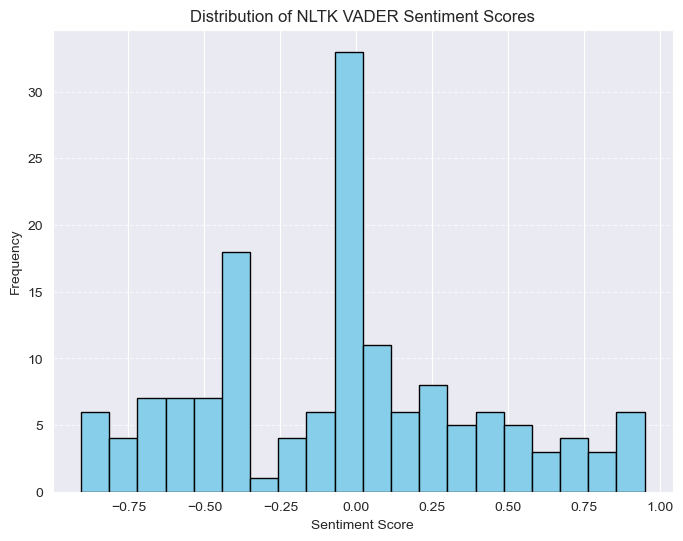

In [16]:
# Create a histogram to visualize the distribution of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(df_nltk['NLTK_Sentiment'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of NLTK VADER Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 3rd Approach with BERT

#### Short intro
**B**idirectional **E**ncoder **R**epresentations from **T**ransformers (**BERT**) is a family of language models introduced in 2018 by researchers at Google.
BERT is an "encoder-only" transformer architecture.

On a high level, BERT consists of three modules:

- **embedding**. This module converts an array of one-hot encoded tokens into an array of vectors representing the tokens.
- a **stack of encoders**. These encoders are the Transformer encoders. They perform transformations over the array of representation vectors.
- **un-embedding**. This module converts the final representation vectors into one-hot encoded tokens again.

There are different BERT models available out there.

**BERT-Large (e.g., bert-large-uncased):**
- one of the largest versions of BERT, with more parameters, making it capable of handling longer text
- high accuracy; can capture detailed context
- requires substantial computational resources and may be slower to run

**RoBERTa (e.g., roberta-large):**
- similar to BERT, but fine-tuned for better performance
- has been optimized for efficiency, can handle longer text as well
- often performs at par with BERT-Large but with lower computational requirements

**Longformer (e.g., allenai/longformer-large-4096):**
- designed specifically for handling long documents and sequences
- well-suited for tasks involving lengthy text, like news articles
- significantly extends the maximum token limit (e.g., up to 4096 tokens) compared to traditional BERT models

**Electra (e.g., google/electra-large-discriminator):**
- efficient and performs well on various NLP tasks
- not explicitly designed for long text, but it can still be used for document-level sentiment analysis effectively

**DistilBERT (e.g., distilbert-base-uncased):**
- smaller and more efficient version of BERT.
- may have limitations in handling very long texts due to its reduced model size

#### Result
BERT-Large might be used if resources can handle it. If not, RoBERTa will receive a try.
First try however, due to it being suited for news texts is Longformer.
Electra and DistilBERT don't appear to be good choices.

#### Using BERT-Large

In [17]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the BERT-Large model and tokenizer
used_approach = "BERT-Large" #setting it for later reference

model_name = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
model.eval()

# Create lists to store the results
sentiments = []

# Record the start time
start_time = time.time()

# Loop through each row in the DataFrame
for current_row, (index, row) in enumerate(df_bert_large.iterrows(), start=1):
    text = row['Cleaned_Text']

    # Pre-process the text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    # Perform sentiment analysis
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=1)  # Use the PyTorch softmax function

    # Extract the predicted sentiment label
    predicted_label = torch.argmax(probabilities).item()  # NOTE: Only labels are easily available from BERT, no raw sentiment score or similar.
    sentiment_labels = ["Negative", "Neutral", "Positive"]  # Customize as needed
    predicted_sentiment = sentiment_labels[predicted_label]

    # Append the result to the lists
    sentiments.append(predicted_sentiment)

    # Print progress update
    print(f"Analyzing text number {current_row} out of {total_rows} rows in the input file.")

# Add the sentiments and the raw sentiment scores as new columns to the DataFrame
df_bert_large['BERT_Large_Sentiment'] = sentiments

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print("-"*100)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Analyzing text number 1 out of 150 rows in the input file.
Analyzing text number 2 out of 150 rows in the input file.
Analyzing text number 3 out of 150 rows in the input file.
Analyzing text number 4 out of 150 rows in the input file.
Analyzing text number 5 out of 150 rows in the input file.
Analyzing text number 6 out of 150 rows in the input file.
Analyzing text number 7 out of 150 rows in the input file.
Analyzing text number 8 out of 150 rows in the input file.
Analyzing text number 9 out of 150 rows in the input file.
Analyzing text number 10 out of 150 rows in the input file.
Analyzing text number 11 out of 150 rows in the input file.
Analyzing text number 12 out of 150 rows in the input file.
Analyzing text number 13 out of 150 rows in the input file.
Analyzing text number 14 out of 150 rows in the input file.
Analyzing text number 15 out of 150 rows in the input file.
Analyzing text number 16 out of 150 rows in the input file.
Analyzing text number 17 out of 150 rows in the i

In [18]:
# Calculate hours, minutes, and seconds from the elapsed time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

# Format the elapsed time string
elapsed_time_str = f"{hours} hours, {minutes} mins, and {seconds} secs"

# End information about the run
print(f"The used approach was {used_approach}.")
print(f"Elapsed time: {elapsed_time_str}.")

The used approach was BERT-Large.
Elapsed time: 0 hours, 6 mins, and 58 secs.


In [19]:
# Saving the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to an Excel file
excel_output_file_BERT_large = os.path.join(output_folder, 'sentiment_results_BERT_large.xlsx')
df_bert_large.to_excel(excel_output_file_BERT_large, index=False)

# Save the results to a csv file with the same name
csv_output_file_BERT_large = os.path.join(output_folder, 'sentiment_results_BERT_large.csv')
df_bert_large.to_csv(csv_output_file_BERT_large, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_BERT_large} and {excel_output_file_BERT_large}.")

Results saved as data/sentiment_results\sentiment_results_BERT_large.csv and data/sentiment_results\sentiment_results_BERT_large.xlsx.


#### Explorative Analysis of BERT-Large

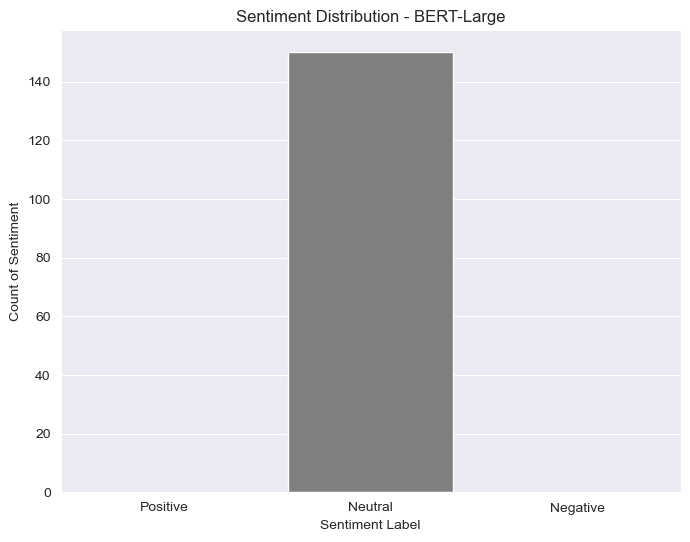

In [20]:
# Count the occurrences of each sentiment label
sentiment_counts = df_bert_large['BERT_Large_Sentiment'].value_counts()

# Define the order of sentiment categories
sentiment_order = ['Positive', 'Neutral', 'Negative']

# Define colors for the sentiment categories
colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}

# Create a bar plot (histogram) for sentiment distribution with correct colors and order
plt.figure(figsize=(8, 6))
sns.set_palette([colors[s] for s in sentiment_order])
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, order=sentiment_order)
plt.title('Sentiment Distribution - BERT-Large')
plt.xlabel('Sentiment Label')
plt.ylabel('Count of Sentiment')

plt.show()

#### Using RoBERTa

In [21]:
# Load the RoBERTa model and tokenizer
used_approach = "RoBERTa"  # setting it for later reference
model_name = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)
model.eval()

# Create a list to store the results
sentiments = []

# Record the start time
start_time = time.time()

# Loop through each row in the DataFrame
for current_row, (index, row) in enumerate(df_bert_roberta.iterrows(), start=1):
    text = row['Cleaned_Text']

    # Pre-process the text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    # Perform sentiment analysis
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=1)  # Use torch.nn.functional.softmax

    # Convert probabilities to a PyTorch tensor
    probabilities = torch.tensor(probabilities)

    # Extract the predicted sentiment label
    predicted_label = torch.argmax(probabilities).item()
    sentiment_labels = ["Negative", "Neutral", "Positive"]  # Customize as needed
    predicted_sentiment = sentiment_labels[predicted_label]

    # Append the result to the list
    sentiments.append(predicted_sentiment)

    # Print progress update
    print(f"Analyzing text number {current_row} out of {total_rows} rows in the input file.")

# Add the sentiments as a new column to the DataFrame
df_bert_roberta['RoBERTa_Sentiment'] = sentiments

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print("-" * 100)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\jannik.labs\AppData\Local\Temp\ipykernel_5436\1661026564.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probabilities = torch.tensor(probabilities)


Analyzing text number 1 out of 150 rows in the input file.
Analyzing text number 2 out of 150 rows in the input file.
Analyzing text number 3 out of 150 rows in the input file.
Analyzing text number 4 out of 150 rows in the input file.
Analyzing text number 5 out of 150 rows in the input file.
Analyzing text number 6 out of 150 rows in the input file.
Analyzing text number 7 out of 150 rows in the input file.
Analyzing text number 8 out of 150 rows in the input file.
Analyzing text number 9 out of 150 rows in the input file.
Analyzing text number 10 out of 150 rows in the input file.
Analyzing text number 11 out of 150 rows in the input file.
Analyzing text number 12 out of 150 rows in the input file.
Analyzing text number 13 out of 150 rows in the input file.
Analyzing text number 14 out of 150 rows in the input file.
Analyzing text number 15 out of 150 rows in the input file.
Analyzing text number 16 out of 150 rows in the input file.
Analyzing text number 17 out of 150 rows in the i

In [22]:
# Calculate hours, minutes, and seconds from the elapsed time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

# Format the elapsed time string
elapsed_time_str = f"{hours} hours, {minutes} mins, and {seconds} secs"

# End information about the run
print(f"The used approach was {used_approach}.")
print(f"Elapsed time: {elapsed_time_str}.")

The used approach was RoBERTa.
Elapsed time: 0 hours, 6 mins, and 53 secs.


In [23]:
# Saving the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to an Excel file
excel_output_file_RoBERTa = os.path.join(output_folder, 'sentiment_results_RoBERTa.xlsx')
df_bert_roberta.to_excel(excel_output_file_RoBERTa, index=False)

# Save the results to a csv file with the same name
csv_output_file_RoBERTa = os.path.join(output_folder, 'sentiment_results_RoBERTa.csv')
df_bert_roberta.to_csv(csv_output_file_RoBERTa, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_RoBERTa} and {excel_output_file_RoBERTa}.")

Results saved as data/sentiment_results\sentiment_results_RoBERTa.csv and data/sentiment_results\sentiment_results_RoBERTa.xlsx.


#### Explorative Analysis of RoBERTa

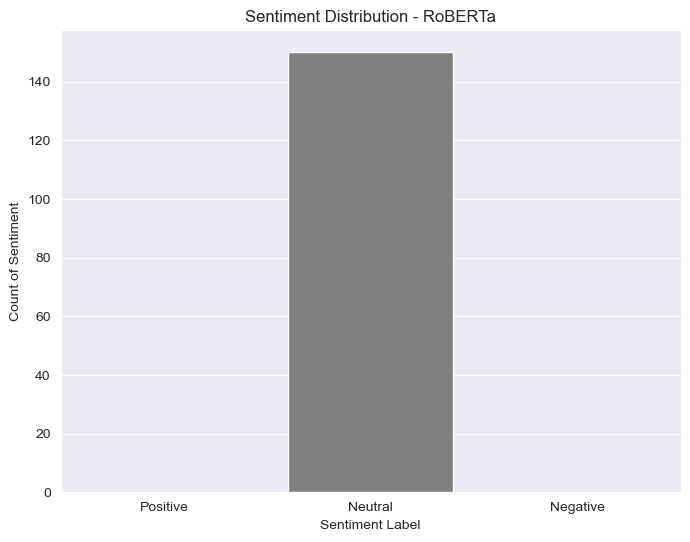

In [24]:
# Count the occurrences of each sentiment label
sentiment_counts = df_bert_roberta['RoBERTa_Sentiment'].value_counts()

# Define the order of sentiment categories
sentiment_order = ['Positive', 'Neutral', 'Negative']

# Define colors for the sentiment categories
colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}

# Create a bar plot (histogram) for sentiment distribution with correct colors and order
plt.figure(figsize=(8, 6))
sns.set_palette([colors[s] for s in sentiment_order])
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, order=sentiment_order)
plt.title('Sentiment Distribution - RoBERTa')
plt.xlabel('Sentiment Label')
plt.ylabel('Count of Sentiment')

plt.show()

#### Using Longformer

In [25]:
# Load the Longformer model and tokenizer
used_approach = "Longformer"  # setting it for later reference
model_name = 'allenai/longformer-base-4096'
tokenizer = LongformerTokenizer.from_pretrained(model_name)
model = LongformerForSequenceClassification.from_pretrained(model_name)
model.eval()

# Create lists to store the results
sentiments = []

# Record the start time
start_time = time.time()

# Loop through each row in the DataFrame
for current_row, (index, row) in enumerate(df_longformer.iterrows(), start=1):
    text = row['Cleaned_Text']

    # Pre-process the text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    # Perform sentiment analysis
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)  # Use torch.softmax

    # Extract the predicted sentiment label
    predicted_label = torch.argmax(probabilities).item()
    sentiment_labels = ["Negative", "Neutral", "Positive"]  # Customize as needed
    predicted_sentiment = sentiment_labels[predicted_label]

    # Append the result to the 'sentiments' list
    sentiments.append(predicted_sentiment)

    # Print progress update
    print(f"Analyzing text number {current_row} out of {total_rows} rows in the input file.")

# Add the sentiments as a new column to the DataFrame
df_longformer['Longformer_Sentiment'] = sentiments

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print("-" * 100)

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Analyzing text number 1 out of 150 rows in the input file.
Analyzing text number 2 out of 150 rows in the input file.
Analyzing text number 3 out of 150 rows in the input file.
Analyzing text number 4 out of 150 rows in the input file.
Analyzing text number 5 out of 150 rows in the input file.
Analyzing text number 6 out of 150 rows in the input file.
Analyzing text number 7 out of 150 rows in the input file.
Analyzing text number 8 out of 150 rows in the input file.
Analyzing text number 9 out of 150 rows in the input file.
Analyzing text number 10 out of 150 rows in the input file.
Analyzing text number 11 out of 150 rows in the input file.
Analyzing text number 12 out of 150 rows in the input file.
Analyzing text number 13 out of 150 rows in the input file.
Analyzing text number 14 out of 150 rows in the input file.
Analyzing text number 15 out of 150 rows in the input file.
Analyzing text number 16 out of 150 rows in the input file.
Analyzing text number 17 out of 150 rows in the i

In [26]:
# Calculate hours, minutes, and seconds from the elapsed time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

# Format the elapsed time string
elapsed_time_str = f"{hours} hours, {minutes} mins, and {seconds} secs"

# End information about the run
print(f"The used approach was {used_approach}.")
print(f"Elapsed time: {elapsed_time_str}.")

The used approach was Longformer.
Elapsed time: 0 hours, 15 mins, and 7 secs.


In [27]:
# Saving the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to an Excel file
excel_output_file_Longformer = os.path.join(output_folder, 'sentiment_results_Longformer.xlsx')
df_longformer.to_excel(excel_output_file_Longformer, index=False)

# Save the results to a csv file with the same name
csv_output_file_Longformer = os.path.join(output_folder, 'sentiment_results_Longformer.csv')
df_longformer.to_csv(csv_output_file_Longformer, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_Longformer} and {excel_output_file_Longformer}.")

Results saved as data/sentiment_results\sentiment_results_Longformer.csv and data/sentiment_results\sentiment_results_Longformer.xlsx.


#### Explorative Analysis of BERT-Longform

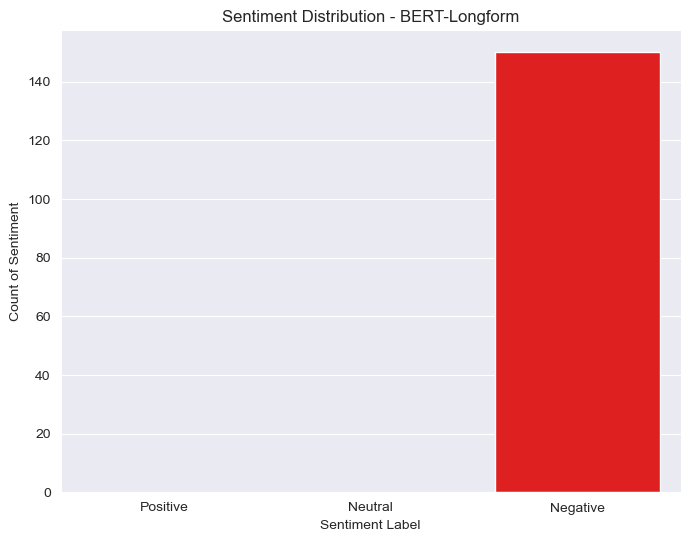

In [28]:
# Count the occurrences of each sentiment label
sentiment_counts = df_longformer['Longformer_Sentiment'].value_counts()

# Define the order of sentiment categories
sentiment_order = ['Positive', 'Neutral', 'Negative']

# Define colors for the sentiment categories
colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}

# Create a bar plot (histogram) for sentiment distribution with correct colors and order
plt.figure(figsize=(8, 6))
sns.set_palette([colors[s] for s in sentiment_order])
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, order=sentiment_order)
plt.title('Sentiment Distribution - BERT-Longform')
plt.xlabel('Sentiment Label')
plt.ylabel('Count of Sentiment')

plt.show()

## Merge Results

In [29]:
# Define a dictionary to store DataFrames for different approaches
df_dict = {}

# Load DataFrames for each approach
approaches = ['textblob', 'nltk', 'bert_large', 'roberta', 'longformer']

for approach in approaches:
    file_path = f'data/sentiment_results/sentiment_results_{approach}.csv'
    df_dict[approach] = pd.read_csv(file_path)

# Initialize merged DataFrame with the first approach (TextBlob)
merged_df = df_dict['textblob']

# Loop through the approaches and merge their DataFrames
for approach in approaches[1:]:
    # Merge based on common columns (adjust as needed)
    merged_df = merged_df.merge(df_dict[approach], on=['Row_Number'], how='inner', suffixes=('', f'_{approach}'))

# After merging the DataFrames, move 'Row_Number' to the first column
merged_df.insert(0, 'Row_Number', merged_df.pop('Row_Number'))
# Now, 'Row_Number' is the first column in merged_df

# Drop not needed, duplicated columns (not best way to do so though)
columns_to_drop = ['Unternehmen_nltk','Newstyp_nltk', 'Quelle_nltk', 'Nearest_Date_nltk', 'Cleaned_Text_nltk', 'Stock_Value_nltk', 'Unternehmen_bert_large', 'Newstyp_bert_large', 'Quelle_bert_large', 'Nearest_Date_bert_large', 'Cleaned_Text_bert_large', 'Stock_Value_bert_large', 'Unternehmen_roberta','Newstyp_roberta', 'Quelle_roberta', 'Nearest_Date_roberta', 'Cleaned_Text_roberta', 'Stock_Value_roberta', 'Unternehmen_longformer','Newstyp_longformer', 'Quelle_longformer', 'Nearest_Date_longformer', 'Cleaned_Text_longformer', 'Stock_Value_longformer']  # Add all columns you want to drop to this list
merged_df.drop(columns=columns_to_drop, inplace=True)


# Define the folder path
output_folder = 'data/sentiment_results/'

# Save the final merged DataFrame to CSV and Excel files in the specified folder path
merged_df.to_csv(os.path.join(output_folder, 'combined_sentiment_results.csv'), index=False)
merged_df.to_excel(os.path.join(output_folder, 'combined_sentiment_results.xlsx'), index=False)

print("Combined sentiment results saved to Excel and CSV files.")

Combined sentiment results saved to Excel and CSV files.
